In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from queue import PriorityQueue
from tqdm import tqdm, notebook
from multiprocessing import Pool, cpu_count
from scipy.signal import savgol_filter
import time

# **1. The Real Environment**

In [ ]:
class RealEnv:
  # initialization
  def __init__(self, L, d, K, minW, maxW, noiseMu, noiseSigma, v0):
    self.arms_vec = np.random.uniform(low= -1, high = 1, size = K * (d-1)).reshape([K, d-1])
    self.arms_vec = normalize(self.arms_vec, axis=1, norm='l2')
    self.arms_vec = np.c_[self.arms_vec, np.ones(K)]
    self.arms_vec = np.r_[np.array([v0]), self.arms_vec]

    self.theta_star = np.random.uniform(low= -1, high = 1, size = L * (d-1)).reshape([L, d-1])
    self.theta_star = normalize(self.theta_star, axis=1, norm='l2')
    self.theta_star = 0.5* np.c_[self.theta_star, np.ones(L)]
    
    self.weight = np.random.uniform(low = minW, high = maxW, size = L)
    self.noiseMu = noiseMu
    self.noiseSigma = noiseSigma

  # generating the reward at each time step t for position l
  def reward_func(self, super_arm, is_reward):
    action_vec = self.arms_vec[super_arm[1]] + self.weight[super_arm[2]-1] * self.arms_vec[super_arm[0]]
    reward = np.matmul(self.theta_star[super_arm[2]-1, :], action_vec.T)
    if is_reward:
      reward = reward + np.random.normal(self.noiseMu, self.noiseSigma, 1)
      # For robustness, this part can be changed to one of the followings: (with adding eps as an additional input)
      # reward = reward + np.exp(self.eps * reward) + np.random.normal(self.noiseMu, self.noiseSigma, 1)
      # reward = reward = reward + self.eps * np.random.laplace(0, 1, 1)
    return reward
  
  def ask_weight(self):
    return self.weight
  
  def ask_arms_vectors(self):
    return self.arms_vec
  
  def return_parameters(self):
    return self.theta_star

# **2. The $L$-layered Graph $G$**

In [ ]:
class LayeredGraph:
  # initialization
  def __init__(self, K, L):
    self.L = L
    self.K = K
    self.vertices = set([(i, j, l) for i in range(1, K+1) for j in range(1, K+1) for l in range(2, L+1)])
    self.vertices = self.vertices.union(set([(0, i, 1) for i in range(1, K+1)]))
    self.edges = dict.fromkeys(self.vertices)

    for vertex in self.vertices:
      if vertex[2] == L:
        continue
      self.edges[vertex] = dict.fromkeys(set([(vertex[1], i, vertex[2]+1) for i in range(1, K+1)]), 0.0)
    
    self.visited = []
    
  def update_weights(self, vertex1, vertex2, weight):
    self.edges[vertex1][vertex2] = weight
    return
  
  def return_weights(self, vertex1, vertex2):
    return self.edges[vertex1][vertex2]
  
  def return_graph(self):
    return self.vertices, self.edges
  
  # finding the shortest path with unweighted length L
  def shortest_path(self, start_vertex, distance_dict, parents_dict):
    valid_dict = {v: distance_dict[v] for v in [(i, j, self.L) for i in range(1, self.K+1) for j in range(1, self.K+1)]}
    end_vertex = min(valid_dict, key=valid_dict.get)

    path = [end_vertex]
    while True:
      key = parents_dict[path[0]]
      path.insert(0, key)
      if key == start_vertex:
        break
    return path, distance_dict[end_vertex]
  
  # finding the weighted shortest path
  def dijkstra(self, start_vertex):
    self.visited = []
    distance_dict = {vertex: float('inf') for vertex in self.vertices}
    distance_dict[start_vertex] = 0

    parents = {}

    # This part can be written for each G_i by using multiprocessing similar to Part 5
    pq = PriorityQueue()
    pq.put((0, start_vertex))

    while not pq.empty():
      (dist, current_vertex) = pq.get()
      self.visited.append(current_vertex)

      for neighbor in self.vertices:
        if self.edges[current_vertex] == None:
          continue
        if neighbor in self.edges[current_vertex]:
          distance = self.edges[current_vertex][neighbor]
          if neighbor not in self.visited:
            old_cost = distance_dict[neighbor]
            new_cost = distance_dict[current_vertex] + distance
            if new_cost < old_cost:
              pq.put((new_cost, neighbor))
              distance_dict[neighbor] = new_cost
              parents[neighbor] = current_vertex
    
    shortest_path, shortest_length = self.shortest_path(start_vertex, distance_dict, parents)
    return shortest_path, shortest_length

# **3. Policies: RankUCB, genRankUCB, RankTS**

In [ ]:
class RankUCBPolicy:
  # initializing
  def __init__(self, lam, L, K, d, weights, arms_vec, delta):
    self.lam = lam
    self.L = L
    self.K = K
    self.d = d
    self.weights = weights
    self.arms_vec = arms_vec
    self.theta = [np.zeros(d) for l in range(L)]
    self.matrix_V = lam * [np.eye(d, d) for l in range(L)]
    self.UCBGraph = LayeredGraph(K, L)
    self.start_vertices = set([(0, i, 1) for i in range(1, K+1)])
    self.last_action = []
    self.last_reward = np.zeros(L)
    self.accumulative_vec = [np.zeros((d, 1)) for l in range(L)]
    self.alpha = 1 + np.sqrt(math.log(2/delta)/2)

  # finding the best action
  def choose_action(self):
    possible_paths = {start_vertex : self.UCBGraph.dijkstra(start_vertex) for start_vertex in self.start_vertices}
    final_path = min(possible_paths.items(), key=lambda x: x[1][1])
    self.last_action = final_path[1][0]
    return final_path[1][0], final_path[1][1]
  
  def receive_reward(self, reward_vec):
    self.last_reward = reward_vec
    return
  
  def update_parameters(self):
    for l in range(self.L):
      # update matrix V
      vec = self.arms_vec[self.last_action[l][1], :] + self.weights[l] * self.arms_vec[self.last_action[l][0], :]
      self.matrix_V[l] = self.matrix_V[l] + np.outer(vec, vec)

      # update accumulative vector
      self.accumulative_vec[l] = np.add(self.accumulative_vec[l].T, vec * self.last_reward[l]).reshape(self.d, 1)

      # update theta
      self.theta[l] = np.linalg.inv(self.matrix_V[l]).dot(self.accumulative_vec[l])

    vertices, edges = self.UCBGraph.return_graph()
    max_edge_weight = 0
    UCB_weights = dict()

    for vertex in vertices:
      vertex_super_arm = self.arms_vec[vertex[1], :] + self.weights[vertex[2]-1] * self.arms_vec[vertex[0], :]

      vertex_UCB = self.theta[vertex[2]-1].T.dot(vertex_super_arm) + self.alpha * np.sqrt(vertex_super_arm.dot(np.linalg.inv(self.matrix_V[vertex[2]-1]).dot(vertex_super_arm)))
                
      if vertex[2] in [1, self.L]:
        vertex_UCB = 2 * vertex_UCB
      UCB_weights[vertex] = vertex_UCB
      if vertex_UCB > max_edge_weight:
        max_edge_weight = vertex_UCB
    
    # update the edges of the UCBGraph -- the edges should be updated for graph -G
    for vertex in vertices:
      if edges[vertex] == None:
        continue
      for neighbor in edges[vertex]:
        estimated_weight = 0.5 * (max_edge_weight - UCB_weights[vertex] + max_edge_weight - UCB_weights[neighbor])
        self.UCBGraph.update_weights(vertex, neighbor, estimated_weight)
    
    return

  def return_model_graph(self):
    return self.UCBGraph

In [ ]:
class genRankUCBPolicy:
  # initializing
  def __init__(self, lam, L, K, d, arms_vec, delta):
    self.lam = lam
    self.L = L
    self.K = K
    self.d = d
    self.arms_vec = arms_vec
    self.phi = [np.zeros(2 * d) for l in range(L)]
    self.matrix_V = lam * [np.eye(2* d, 2* d) for l in range(L)]
    self.UCBGraph = LayeredGraph(K, L)
    self.start_vertices = set([(0, i, 1) for i in range(1, K+1)])
    self.last_action = []
    self.last_reward = np.zeros(L)
    self.accumulative_vec = [np.zeros((2 * d, 1)) for l in range(L)]
    self.alpha = 1 + np.sqrt(math.log(2/delta)/2)

  # finding the best action
  def choose_action(self):
    possible_paths = {start_vertex : self.UCBGraph.dijkstra(start_vertex) for start_vertex in self.start_vertices}
    final_path = min(possible_paths.items(), key=lambda x: x[1][1])
    self.last_action = final_path[1][0]
    return final_path[1][0], final_path[1][1]
  
  def receive_reward(self, reward_vec):
    self.last_reward = reward_vec
    return
  
  def update_parameters(self):
    for l in range(self.L):
      # update matrix V
      vec = np.concatenate((self.arms_vec[self.last_action[l][1], :], self.arms_vec[self.last_action[l][0], :]))
      self.matrix_V[l] = self.matrix_V[l] + np.outer(vec, vec)

      # update accumulative vector
      self.accumulative_vec[l] = np.add(self.accumulative_vec[l].T, vec * self.last_reward[l]).reshape(2 * self.d, 1)

      # update theta
      self.phi[l] = np.linalg.inv(self.matrix_V[l]).dot(self.accumulative_vec[l])

    # calculate UCB of each super-arm in each position
    vertices, edges = self.UCBGraph.return_graph()
    max_edge_weight = 0
    UCB_weights = dict()

    for vertex in vertices:
      vertex_super_arm = np.concatenate((self.arms_vec[vertex[1], :] , self.arms_vec[vertex[0], :]))

      vertex_UCB = self.phi[vertex[2]-1].T.dot(vertex_super_arm) + self.alpha * np.sqrt(vertex_super_arm.dot(np.linalg.inv(self.matrix_V[vertex[2]-1]).dot(vertex_super_arm)))
      if vertex[2] in [1, self.L]:
        vertex_UCB = 2 * vertex_UCB
      UCB_weights[vertex] = vertex_UCB
      if vertex_UCB > max_edge_weight:
        max_edge_weight = vertex_UCB
    
    # update the edges of the UCBGraph -- the edges should be updated for graph -G
    for vertex in vertices:
      if edges[vertex] == None:
        continue
      for neighbor in edges[vertex]:
        estimated_weight = 0.5 * (max_edge_weight - UCB_weights[vertex] + max_edge_weight - UCB_weights[neighbor])
        self.UCBGraph.update_weights(vertex, neighbor, estimated_weight)
    
    return

  def return_model_graph(self):
    return self.UCBGraph

In [ ]:
class RankTSPolicy:
  # initializing
  def __init__(self, L, K, d, weights, arms_vec):
    self.L = L
    self.K = K
    self.d = d
    self.weights = weights
    self.arms_vec = arms_vec
    self.mu = [np.zeros(d) for l in range(L)]
    self.sigma_matrix = [np.eye(d, d) for l in range(L)]
    self.TSGraph = LayeredGraph(K, L)
    self.start_vertices = set([(0, i, 1) for i in range(1, K+1)])
    self.last_action = []
    self.last_reward = np.zeros(L)
    self.accumulative_vec = [np.zeros((d, 1)) for l in range(L)]

  # finding the best action
  def choose_action(self):
    possible_paths = {start_vertex : self.TSGraph.dijkstra(start_vertex) for start_vertex in self.start_vertices}
    final_path = min(possible_paths.items(), key=lambda x: x[1][1])
    self.last_action = final_path[1][0]
    return final_path[1][0], final_path[1][1]
  
  def receive_reward(self, reward_vec):
    self.last_reward = reward_vec
    return
  
  def update_parameters(self):
    for l in range(self.L):
      # update mu and sigma
      vec = self.arms_vec[self.last_action[l][1], :] + self.weights[l] * self.arms_vec[self.last_action[l][0], :]
      self.sigma_matrix[l] = self.sigma_matrix[l] + np.outer(vec, vec)

      self.accumulative_vec[l] = np.add(self.accumulative_vec[l].T, vec * self.last_reward[l]).reshape(self.d, 1)
      self.mu[l] = np.linalg.inv(self.sigma_matrix[l]).dot(self.accumulative_vec[l]).reshape(self.d)

    vertices, edges = self.TSGraph.return_graph()
    max_edge_weight = 0
    TS_weights = dict()

    for vertex in vertices:
      vertex_super_arm = self.arms_vec[vertex[1], :] + self.weights[vertex[2]-1] * self.arms_vec[vertex[0], :]
      theta_TS = np.random.multivariate_normal(self.mu[vertex[2]-1], np.linalg.inv(self.sigma_matrix[vertex[2]-1]))
      vertex_TS = theta_TS.T.dot(vertex_super_arm)

      if vertex[2] in [1, self.L]:
        vertex_TS = 2 * vertex_TS
      TS_weights[vertex] = vertex_TS
      if vertex_TS > max_edge_weight:
        max_edge_weight = vertex_TS
    
    # update the edges of the TSGraph -- the edges should be updated for graph -G
    for vertex in vertices:
      if edges[vertex] == None:
        continue
      for neighbor in edges[vertex]:
        estimated_weight = 0.5 * (max_edge_weight - TS_weights[vertex] + max_edge_weight - TS_weights[neighbor])
        self.TSGraph.update_weights(vertex, neighbor, estimated_weight)
    
    return

  def return_model_graph(self):
    return self.TSGraph

# **4. Simulation and Plots**

In [ ]:
def optimal_solution(real_env, real_env_graph, weights, arms_vec, K, L):
  max_edge_weight = 0
  real_weights = dict()
  start_vertices = set([(0, i, 1) for i in range(1, K+1)])

  real_vertices, real_edges = real_env_graph.return_graph()

  for vertex in real_vertices:
    vertex_super_arm = arms_vec[vertex[1], :] + weights[vertex[2]-1] * arms_vec[vertex[0], :]
    vertex_weight = real_env.reward_func(vertex, False)
    if vertex[2] in [1, L]:
      vertex_weight = 2 * vertex_weight
    real_weights[vertex] = vertex_weight
    if vertex_weight > max_edge_weight:
      max_edge_weight = vertex_weight

  for vertex in real_vertices:
    if real_edges[vertex] == None:
      continue
    for neighbor in real_edges[vertex]:
      estimated_weight = 0.5 * (max_edge_weight - real_weights[vertex] + max_edge_weight - real_weights[neighbor])
      real_env_graph.update_weights(vertex, neighbor, estimated_weight)
  
  real_vertices, real_edges = real_env_graph.return_graph()

  possible_paths = {start_vertex : real_env_graph.dijkstra(start_vertex) for start_vertex in start_vertices}
  final_path = min(possible_paths.items(), key=lambda x: x[1][1])
  real_action = final_path[1][0]
  real_reward = [real_env.reward_func(act, False) for act in real_action]

  return real_action, real_reward

In [ ]:
def run_reality(L, d, K, minW, maxW, noiseMu, noiseSigma, v0):
  real_env = RealEnv(L, d, K, minW, maxW, noiseMu, noiseSigma, v0)
  arms_vec = real_env.ask_arms_vectors()
  real_env_graph = LayeredGraph(K, L)
  weights = real_env.ask_weight()

  real_action, real_reward = optimal_solution(real_env, real_env_graph, weights, arms_vec, K, L)
  return real_action, real_reward, weights, arms_vec, real_env

In [ ]:
def run_simulation(T, N, L, d, K, lam, delta, real_reward, weights, arms_vec, real_env, rank_model):
  regret = np.zeros([N, T])

  for n in tqdm(range(N)):
    if rank_model == "RankUCB":
      model = RankUCBPolicy(lam, L, K, d, weights, arms_vec, delta)
    elif rank_model == "genRankUCB":
      model = genRankUCBPolicy(lam, L, K, d, arms_vec, delta)
    else:
      model = RankTSPolicy(L, K, d, weights, arms_vec)
    
    for t in range(T):
      graph = model.return_model_graph()
      vertices, edges = graph.return_graph()
      action, weight = model.choose_action()
      reward = [real_env.reward_func(act, True) for act in action]
      model.receive_reward(reward)
      model.update_parameters()
      
      regret[n][t] = sum(real_reward) - sum(reward)

  return regret

In [ ]:
def plot_regrets(rankUCB_regret, genRankUCB_regret, rankTS_regret, baseline_regret, N):
  expected_rankUCB_regret = rankUCB_regret.sum(axis = 0) / N
  expected_genRankUCB_regret = genRankUCB_regret.sum(axis = 0) / N
  expected_rankTS_regret = rankTS_regret.sum(axis = 0) / N
  expected_baseline_regret = baseline_regret.sum(axis = 0) / N
  
  df = pd.DataFrame({'round': [t for t in range(T)],
                     'rankUCB_regret': expected_rankUCB_regret,
                     'genRankUCB_regret': expected_genRankUCB_regret,
                     'rankTS_regret': expected_rankTS_regret,
                     'baseline': expected_baseline_regret})
  
  fig = plt.figure(figsize=(12, 8))

  SMALL_SIZE = 18
  MEDIUM_SIZE = 22
  BIGGER_SIZE = 24

  plt.rc('font', size=SMALL_SIZE)          
  plt.rc('axes', titlesize=SMALL_SIZE)     
  plt.rc('axes', labelsize=MEDIUM_SIZE)    
  plt.rc('xtick', labelsize=SMALL_SIZE)    
  plt.rc('ytick', labelsize=SMALL_SIZE)    
  plt.rc('legend', fontsize=SMALL_SIZE)    
  plt.rc('figure', titlesize=BIGGER_SIZE)
  
  plt.plot(df["round"], df["rankUCB_regret"], label='rankUCB', linewidth=1, color='purple')
  plt.plot(df["round"], df["rankTS_regret"], label='rankTS', linewidth=1, color='blue')
  plt.plot(df["round"], df["genRankUCB_regret"], label='genRankUCB', linewidth=1, color='orange')
  plt.plot(df["round"], df["baseline"], label='baseline', linewidth=1, color='darkgreen')

  plt.xlabel('Round')
  plt.ylabel('Expected Regret')
  plt.legend()
  plt.tight_layout()

  plt.show()
  return

In [ ]:
def plot_tightness(algo_regret, algo_name, T, N, weights, d, lam, L, delta):
  cumulative_expected_regret = (algo_regret.sum(axis = 0) / N).cumsum()
  max_w = 1 + abs(max(weights, key=abs))
  df = pd.DataFrame({'round': [t for t in range(T)],
                     'cumulative_expected_regret': cumulative_expected_regret})
  
  fig = plt.figure(figsize=(12, 8))

  SMALL_SIZE = 18
  MEDIUM_SIZE = 22
  BIGGER_SIZE = 24

  plt.rc('font', size=SMALL_SIZE)
  plt.rc('axes', titlesize=SMALL_SIZE)
  plt.rc('axes', labelsize=MEDIUM_SIZE)
  plt.rc('xtick', labelsize=SMALL_SIZE)
  plt.rc('ytick', labelsize=SMALL_SIZE)
  plt.rc('legend', fontsize=SMALL_SIZE)
  plt.rc('figure', titlesize=BIGGER_SIZE)

  yhat = df["cumulative_expected_regret"]

  if algo_name == "rankUCB":
    y_algo = 2 * math.sqrt(2) * max_w * L * math.sqrt(d * T * ( 1 + np.sqrt(math.log(2/delta)/2)) * math.log((1+ T * np.power(max_w, 2))/(d * lam)))
  elif algo_name == "rankTS":
    y_algo = 2 * max_w * L * (1 + math.sqrt(2 * d * T * ( 1 + np.sqrt(math.log(2/delta)/2)) * math.log((1+ T * np.power(max_w, 2))/(d * lam))))
  else:
    y_algo = 4 * max_w * L * math.sqrt(d * T * ( 1 + np.sqrt(math.log(2/delta)/2)) * math.log((1+ 2* T)/(d * lam)))

  plt.plot(df["round"], yhat, label='{}'.format(algo_name), linewidth=2, color='blue')
  plt.axhline(y= y_algo, label='Upper bound', linewidth=2, color='red', linestyle='-')
  plt.xlabel('Round')
  plt.ylabel('Cumulative Expected Regret')
  plt.legend()
  plt.tight_layout()

  plt.show()
  return

In [ ]:
def plot_regrets_smooth(rankUCB_regret, genRankUCB_regret, rankTS_regret, i, N):
  expected_rankUCB_regret = rankUCB_regret[i].sum(axis = 0) / N
  expected_genRankUCB_regret = genRankUCB_regret[i].sum(axis = 0) / N
  expected_rankTS_regret = rankTS_regret[i].sum(axis = 0) / N
  
  df = pd.DataFrame({'round': [t for t in range(T)],
                     'rankUCB_regret': expected_rankUCB_regret,
                     'genRankUCB_regret': expected_genRankUCB_regret,
                     'rankTS_regret': expected_rankTS_regret})
  
  fig = plt.figure(figsize=(12, 8))

  SMALL_SIZE = 18
  MEDIUM_SIZE = 22
  BIGGER_SIZE = 24

  plt.rc('font', size=SMALL_SIZE)          
  plt.rc('axes', titlesize=SMALL_SIZE)     
  plt.rc('axes', labelsize=MEDIUM_SIZE)    
  plt.rc('xtick', labelsize=SMALL_SIZE)    
  plt.rc('ytick', labelsize=SMALL_SIZE)    
  plt.rc('legend', fontsize=SMALL_SIZE)    
  plt.rc('figure', titlesize=BIGGER_SIZE)

  ucb_yhat = savgol_filter(expected_rankUCB_regret, 99, 2)
  genucb_yhat = savgol_filter(expected_genRankUCB_regret, 99, 2)
  ts_yhat = savgol_filter(expected_rankTS_regret, 99, 2)

  plt.plot(df["round"], ucb_yhat, label='rankUCB', linewidth=2, color='purple')
  plt.plot(df["round"], genucb_yhat, label='genRankUCB', linewidth=2, color='orange')
  plt.plot(df["round"], ts_yhat, label='rankTS', linewidth=2, color='blue')

  plt.xlabel('Round')
  plt.ylabel('Expected Regret')
  plt.legend()
  plt.tight_layout()

  plt.show()
  return

# **5. Running the models**

In [ ]:
T = 10000
N = 100

noiseMu = 0
noiseSigma = 1

lam = 1
delta = 0.1

d = 5
allK = [10, 100]
L = 4

# Add eps here and pass it as args to run_simulation if needed

v0 = np.zeros(d)

minW = -2
maxW = 2

rankUCB_regret = []
genRankUCB_regret = []
rankTS_regret = []
baseline_regret = []


for i in range(len(allK)):
  K = allK[i]

  pool = Pool(processes=(cpu_count()-1))
  real_action, real_reward, weights, arms_vec, real_env = run_reality(L, d, K, minW, maxW, noiseMu, noiseSigma, v0)

  pool.apply_async(run_simulation, args=(T, N, L, d, K, lam, delta, real_reward, weights, arms_vec, real_env, "RankUCB"), callback=rankUCB_regret.append)
  pool.apply_async(run_simulation, args=(T, N, L, d, K, lam, delta, real_reward, weights, arms_vec, real_env, "genRankUCB"), callback=genRankUCB_regret.append)

  pool.apply_async(run_simulation, args=(T, N, L, d, K, lam, delta, real_reward, weights, arms_vec, real_env, "RankTS"), callback=rankTS_regret.append)
  pool.apply_async(run_simulation, args=(T, N, L, d, K, lam, delta, real_reward, np.zeros(L), arms_vec, real_env, "RankUCB"), callback=baseline_regret.append)

  pool.close()
  pool.join()

  plot_regrets(rankUCB_regret[i], genRankUCB_regret[i], rankTS_regret[i], baseline_regret[i], N)

# **6. Examples**

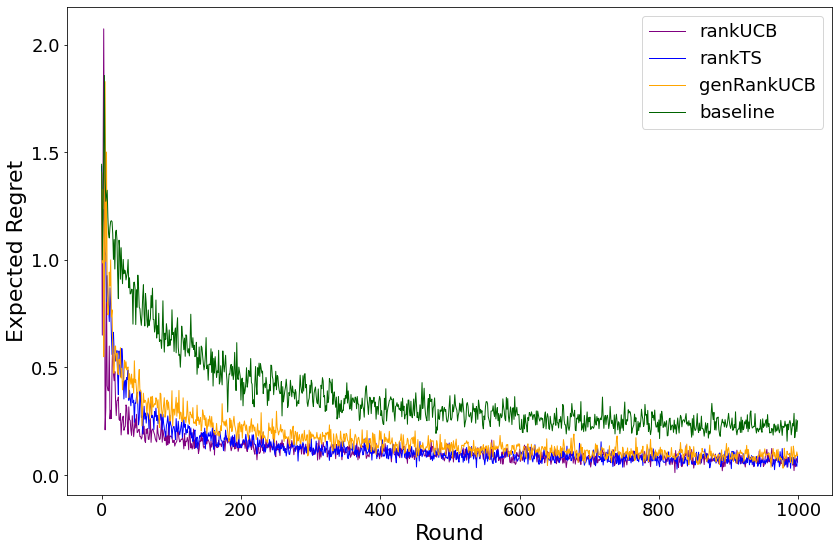

In [ ]:
plot_regrets(rankUCB_regret[i], genRankUCB_regret[i], rankTS_regret[i], baseline_regret[i], N)

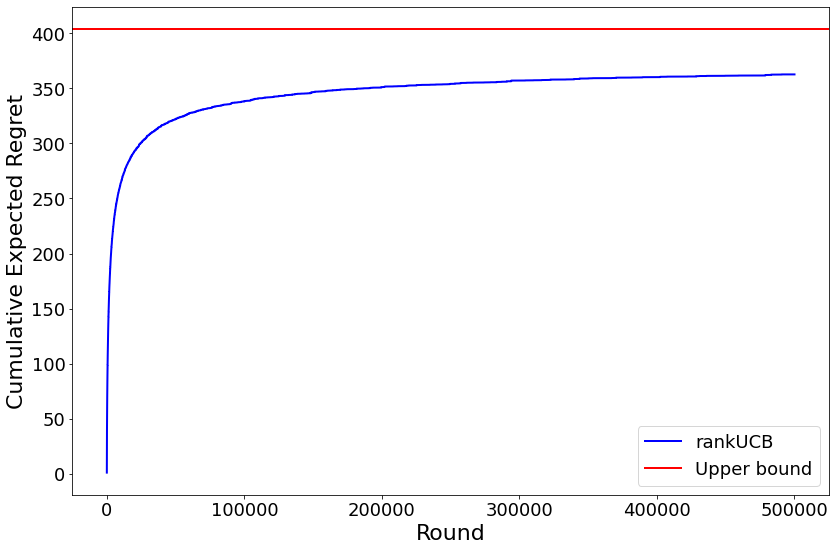

In [ ]:
plot_tightness(rankUCB_regret[i], "rankUCB", T, N, weights, d, lam, L, delta)